## Project: Development of a reduced pediatric injury prediction model
Created by: Thomas Hartka, MD, MS  
Date created: 12/20/20  
  
This notebook the maximum AUC for models with different numbers of variables.  We also create the same plot, but exclude delta-V as a predictor.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import FormatStrFormatter

## Set outcome

In [2]:
# outcome of interest
#  ISS -> ISS>=16
#  TIL -> any injury on target injury list
outcome = "ISS"

## Read in results

In [3]:
if outcome == "ISS":
    results = pd.read_csv("../Results/Model_avg_10x-ext_pred-ISS.csv")
elif outcome == "TIL":
    results = pd.read_csv("../Results/Model_avg_10x-ext_pred-TIL.csv")
else:
    raise Exception("Outcome not valid") 

In [4]:
predictors = ['sex','age_5_9', 'age_10_14','age_15_18',
              'prop_restraint','any_restraint','front_row', 
              'dvtotal','pdof_rear','pdof_nearside','pdof_farside', 
              'rolled','multicoll','ejection',
              'splimit','abdeply','entrapment']

## Calculate mean and 95% CI of AUCs

In [5]:
# copy into new dataframe for binary variables instead of coefficients
results_bin = results.copy()

# convert cofficients to binary flags
results_bin[predictors] = results[predictors].applymap(lambda x: 1 if x!=0 else 0) 

In [6]:
# calculate mean and standard deviation of all models
mean_AUC = results_bin.groupby(['num_vars']+predictors)['AUC'].agg(['mean', 'std'])

# find max mean AUC for each number of variables and select for those rows
max_idx = mean_AUC.groupby(['num_vars'])['mean'].transform(max) == mean_AUC['mean']
max_AUC = mean_AUC[max_idx].reset_index()

# calculate lower and upper 95% CI
max_AUC['LL'] = max_AUC['mean'] - 1.96*max_AUC['std']
max_AUC['UL'] = max_AUC['mean'] + 1.96*max_AUC['std']

# discard unneeded columns
max_AUC = max_AUC[['num_vars','mean','LL','UL']]

max_AUC

,num_vars,mean,LL,UL
0,1.0,0.843673,0.809913,0.877433
1,2.0,0.878240,0.849545,0.906934
2,3.0,0.888120,0.856909,0.919330
3,4.0,0.896752,0.862228,0.931275
4,5.0,0.903603,0.866778,0.940427
5,6.0,0.907954,0.869581,0.946326
6,7.0,0.909470,0.868685,0.950255
7,8.0,0.909986,0.869449,0.950524
8,9.0,0.910587,0.869788,0.951385
9,10.0,0.910561,0.869817,0.951306


## Calculate stat significant decrease in AUC

In [7]:
# store base model results
base_distrib = results_bin[results_bin.num_vars==len(predictors)]['AUC']

# create arrary for max p-values
max_p = [0] * len(predictors)

# group results by model
results_grp = results_bin.groupby(['num_vars']+predictors)['AUC']

# iterate through models
for num_vars, model_results in results_grp:
    # compare to baseline model
    p = stats.ttest_rel(base_distrib, model_results).pvalue
    
    # test if this is the highest p-value
    if p > max_p[num_vars[0].astype(int)-1]:
        max_p[num_vars[0].astype(int)-1] = p
    # if the distributions are identical
    elif np.isnan(p):
        max_p[num_vars[0].astype(int)-1] = 1.0

max_p

[0.00010323811878019266,
 0.0012631499166519437,
 0.004430104562540711,
 0.01992120755975954,
 0.04583111248906924,
 0.5598129340178464,
 0.8463883433974883,
 0.9966174753603776,
 0.9989527604698323,
 0.9955557908924153,
 0.9992137226480591,
 0.9958220049032014,
 0.9951744710437853,
 0.9966632679722051,
 0.9982248886880017,
 0.9898096398220573,
 1.0]

In [8]:
# loop through variable numbers
for i in range(0,len(predictors)):
    
    # check if best model is statistically sig different than base model
    if max_p[i] > 0.05:
        
        # if so, store value and break
        num_var_sd = i
        break

num_var_sd

5

## Plot AUC versus number of variables

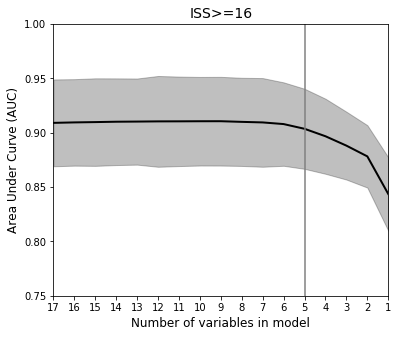

In [9]:
# set up plot
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

# add data for line plot and 95% CI 
ax.plot(max_AUC['num_vars'], max_AUC['mean'], marker='', color='black', linewidth=2, alpha=1)
ax.fill_between(max_AUC['num_vars'], max_AUC['LL'], max_AUC['UL'],color='black',alpha=0.25)

# set plot limits
plt.ylim(0.75, 1.0)
plt.xlim(13, 1)

# add line for statistically sign decrease in AUC
ax.axvline(x=num_var_sd, linestyle='-', color='grey')

# correct tick marks
ax.set_xticks(max_AUC['num_vars'].unique())

# label axes
plt.xlabel('Number of variables in model', fontsize=12)
plt.ylabel('Area Under Curve (AUC)', fontsize=12)

# title
if outcome == "ISS":
    plt.title("ISS>=16", fontsize=14)
elif outcome == "TIL":
    plt.title("Target injury list", fontsize=14)

plt.show()

## Calculate AUC excluding models with delta-V

In [10]:
# copy into new dataframe but only include models without delta-V
results_bin_wo_dv = results[results.dvtotal==0].copy()

# convert cofficients to binary flags
results_bin_wo_dv[predictors] = results_bin_wo_dv[predictors].applymap(lambda x: 1 if x!=0 else 0) 

# calculate mean and standard deviation of all models
mean_AUC_wo_dv = results_bin_wo_dv.groupby(['num_vars']+predictors)['AUC'].agg(['mean', 'std'])

# find max mean AUC for each number of variables and select for those rows
max_idx_wo_dv = mean_AUC_wo_dv.groupby(['num_vars'])['mean'].transform(max) == mean_AUC_wo_dv['mean']
max_AUC_wo_dv = mean_AUC_wo_dv[max_idx_wo_dv].reset_index()

# calculate lower and upper 95% CI
max_AUC_wo_dv['LL'] = max_AUC_wo_dv['mean'] - 1.96*max_AUC_wo_dv['std']
max_AUC_wo_dv['UL'] = max_AUC_wo_dv['mean'] + 1.96*max_AUC_wo_dv['std']

## Calculate stat significant decrease in AUC excluding delta-V

In [11]:
# store base model results
base_distrib = results_bin_wo_dv[results_bin_wo_dv.num_vars==(len(predictors)-1)]['AUC']

# create arrary for max p-values
max_p_wo_dv = [0] * (len(predictors)-1)

# group results by model
results_grp = results_bin_wo_dv.groupby(['num_vars']+predictors)['AUC']

# iterate through models
for num_vars, model_results in results_grp:
    # compare to baseline model
    p = stats.ttest_rel(base_distrib, model_results).pvalue
    
    # test if this is the highest p-value
    if p > max_p_wo_dv[num_vars[0].astype(int)-1]:
        max_p_wo_dv[num_vars[0].astype(int)-1] = p
    # if the distributions are identical
    elif np.isnan(p):
        max_p_wo_dv[num_vars[0].astype(int)-1] = 1.0

max_p_wo_dv

[3.877465878956986e-07,
 9.532044488182179e-06,
 0.00021490769774016363,
 0.002100780092013104,
 0.013191425916894137,
 0.03932185360872966,
 0.2510853048926532,
 0.5047595441439972,
 0.9451334849911126,
 0.9424637477606023,
 0.9930719366744554,
 0.9957931286873651,
 0.9778645380474235,
 0.9679156299324521,
 0.933019635516261,
 1.0]

In [12]:
# loop through variable numbers
for i in range(0,len(predictors)-1):
    
    # check if best model is statistically sig different than base model
    if max_p_wo_dv[i] > 0.05:
        
        # if so, store value and break
        num_var_sd_wo_dv = i
        break

num_var_sd_wo_dv

6

## Plot AUC vs variable number excluding delta-V

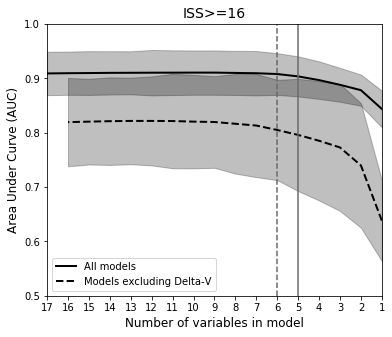

In [13]:
# set up plot
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

# add data for line plot and 95% CI 
ax.plot(max_AUC['num_vars'], max_AUC['mean'], color='black', linewidth=2, alpha=1, label='All models')
ax.plot(max_AUC_wo_dv['num_vars'], max_AUC_wo_dv['mean'], linestyle='--', color='black', linewidth=2, alpha=1, label="Models excluding Delta-V")
ax.fill_between(max_AUC['num_vars'], max_AUC['LL'], max_AUC['UL'],color='black',alpha=0.25)
ax.fill_between(max_AUC_wo_dv['num_vars'], max_AUC_wo_dv['LL'], max_AUC_wo_dv['UL'],color='black',alpha=0.25)
#ax.fill_between(max_AUC_wo_dv['num_vars'], max_AUC_wo_dv['LL'], max_AUC_wo_dv['UL'],color='black',alpha=0.25,hatch="/")

# set plot limits
plt.ylim(0.5, 1.0)
plt.xlim(13, 1)

# add line for statistically sign decrease in AUC
ax.axvline(x=num_var_sd, linestyle='-', color='dimgrey')
ax.axvline(x=num_var_sd_wo_dv, linestyle='--', color='dimgrey')

# correct tick marks
ax.set_xticks(max_AUC['num_vars'].unique())

# add legend
plt.legend(loc="lower left")

# label axes
plt.xlabel('Number of variables in model', fontsize=12)
plt.ylabel('Area Under Curve (AUC)', fontsize=12)

# title
if outcome == "ISS":
    plt.title("ISS>=16", fontsize=14)
elif outcome == "TIL":
    plt.title("Target injury list", fontsize=14)

plt.show()

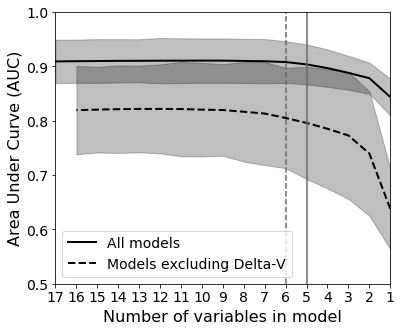

In [14]:
# set up plot
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

# add data for line plot and 95% CI 
ax.plot(max_AUC['num_vars'], max_AUC['mean'], color='black', linewidth=2, alpha=1, label='All models')
ax.plot(max_AUC_wo_dv['num_vars'], max_AUC_wo_dv['mean'], linestyle='--', color='black', linewidth=2, alpha=1, label="Models excluding Delta-V")
ax.fill_between(max_AUC['num_vars'], max_AUC['LL'], max_AUC['UL'],color='black',alpha=0.25)
ax.fill_between(max_AUC_wo_dv['num_vars'], max_AUC_wo_dv['LL'], max_AUC_wo_dv['UL'],color='black',alpha=0.25)
#ax.fill_between(max_AUC_wo_dv['num_vars'], max_AUC_wo_dv['LL'], max_AUC_wo_dv['UL'],color='black',alpha=0.25,hatch="/")

# set plot limits
plt.ylim(0.5, 1.0)
plt.xlim(13, 1)

# add line for statistically sign decrease in AUC
ax.axvline(x=num_var_sd, linestyle='-', color='dimgrey')
ax.axvline(x=num_var_sd_wo_dv, linestyle='--', color='dimgrey')

# correct tick marks
ax.set_xticks(max_AUC['num_vars'].unique())

# add legend
plt.legend(loc="lower left", fontsize=14)

# label axes
plt.xlabel('Number of variables in model', fontsize=16)
plt.ylabel('Area Under Curve (AUC)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.show()

In [15]:
max_AUC

,num_vars,mean,LL,UL
0,1.0,0.843673,0.809913,0.877433
1,2.0,0.878240,0.849545,0.906934
2,3.0,0.888120,0.856909,0.919330
3,4.0,0.896752,0.862228,0.931275
4,5.0,0.903603,0.866778,0.940427
5,6.0,0.907954,0.869581,0.946326
6,7.0,0.909470,0.868685,0.950255
7,8.0,0.909986,0.869449,0.950524
8,9.0,0.910587,0.869788,0.951385
9,10.0,0.910561,0.869817,0.951306


In [16]:
max_AUC_wo_dv

,num_vars,sex,age_5_9,age_10_14,age_15_18,prop_restraint,any_restraint,front_row,dvtotal,pdof_rear,...,rolled,multicoll,ejection,splimit,abdeply,entrapment,mean,std,LL,UL
0,1.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0.638103,0.037935,0.563750,0.712456
1,2.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0.739700,0.058428,0.625182,0.854219
2,3.0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0.772894,0.059597,0.656083,0.889704
3,4.0,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,1,0.785183,0.056017,0.675390,0.894976
4,5.0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,1,0.795935,0.052683,0.692675,0.899194
5,6.0,0,0,0,0,0,1,0,0,0,...,0,0,1,1,1,1,0.805000,0.047037,0.712807,0.897193
6,7.0,0,0,0,0,0,1,0,0,0,...,0,1,1,1,1,1,0.813197,0.048417,0.718300,0.908093
7,8.0,0,0,0,0,0,1,0,0,1,...,0,1,1,1,1,1,0.816453,0.046763,0.724797,0.908110
8,9.0,0,1,0,0,0,1,0,0,1,...,0,1,1,1,1,1,0.819708,0.042993,0.735442,0.903975
9,10.0,0,1,1,0,0,1,0,0,1,...,0,1,1,1,1,1,0.820414,0.043892,0.734385,0.906442
